---
# VisionSpace Challenge
---
### Description
This Notebook includes all solutions and explainations of all three challenges.
### Requierements
The following cell installs all packages that I used to solve the tasks.
*TODO: Explain the packages*




In [ ]:
%pip install pandas
%pip install matplotlib
%pip install numpy
%pip install tensorflow 
%pip install scikit-learn

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from src.functions import *

# Challenge I
---
## Desciption
The Janus satellite provides information that supports ground exploration missions on Mars. A sample
of the dataset in .csv format and a short description of its columns can be found in this repository:
https://github.com/visionspacetec/ai-interview-challanges
Your goal is to apply Machine Learning techniques to predict Janus’ power consumption.
## Solution
Assumption: As the exact predition goal is not further specified, I set it to a next-hour prediction, this also aligns well with real-time monitoring needs and can be helpful to determine anomalies. Another possibility would be to predict the next 24-hour profile which would be useful for battery planning or solar panel alignment. I decided against this goal as the data set includes only around 20 days and therefore such a prediciton would be really challenging because there might be long-term trends or periodic variations that are not captured by the data.

In [3]:
current_dir_path = os.getcwd()
data_file_path = os.path.join(current_dir_path, 'SatelliteDataSet.csv')

df = pd.read_csv(data_file_path)

features = ["power", 
            "sunmars_km",
            "earthmars_km", 
            "sunmarsearthangle_deg", 
            "solarconstantmars",  
            #"occultationduration_min",
            "ACROSS_TRACK", 
            #"NADIR",
            "D1PVMC", 
            "EARTH",
            "MAINTENANCE"
            ]

#All features
all_features = ["power", "sa", "sx", "sy", "sz", "sunmars_km", 
            "earthmars_km", "sunmarsearthangle_deg", 
            "solarconstantmars", "eclipseduration_min", 
            "occultationduration_min", "flagcomms", 
            "ACROSS_TRACK", "D1PVMC", "D4PNPO", "EARTH", "INERTIAL",
            "MAINTENANCE", "NADIR", "RADIO_SCIENCE", "SLEW", "WARMUP"]

target = "power"

# Data Engineering


In [3]:
# Compute correlation of power consumption with each feature
calc_corr_of_feature(df, all_features, target)

power corr: 0.9999999999999999
sa corr: -0.020544560234196263
sx corr: -0.06295831848175014
sy corr: 0.04444490970557691
sz corr: -0.020810284280368536
sunmars_km corr: 0.19974244640596475
earthmars_km corr: -0.20639710818444582
sunmarsearthangle_deg corr: 0.2012390740042775
solarconstantmars corr: -0.19919449142335285
eclipseduration_min corr: 0.09782691747868208
occultationduration_min corr: 0.19605991498185174
flagcomms corr: -0.014790854659758542
ACROSS_TRACK corr: -0.019210438752246244
D1PVMC corr: 0.04161951677793841
D4PNPO corr: nan
EARTH corr: 0.06577656586324652
INERTIAL corr: 0.029458595105856144
MAINTENANCE corr: 0.06140619358855068
NADIR corr: -0.02896509419077095
RADIO_SCIENCE corr: nan
SLEW corr: -0.01360517039572094
WARMUP corr: 0.006998950094716731


c:\Users\Diema2\Desktop\vs_challenge\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Diema2\Desktop\vs_challenge\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [4]:
# Derived Features: 5-hour mean, day hour, effective solar power, check which commands have impact on power

df['power_mean_3h'] = df['power'].rolling(window=3, min_periods=1).mean()
features.append("power_mean_5h")

df['power_mean_5h'] = df['power'].rolling(window=5, min_periods=1).mean()
features.append("power_mean_5h")

#df['ut_ms'] = pd.to_datetime(df['ut_ms'], format='%Y-%m-%d %H:%M:%S')
#df['hour_of_day'] = df['ut_ms'].dt.hour
#features.append('hour_of_day')
#
#df["sa"] = df["sa"].apply(np.deg2rad).apply(np.cos)
#df['solar_power'] = df['sa'] * df['solarconstantmars']
#features.append('solar_power')

# Apply trigonomic function to degree
#df[["sunmarsearthangle_deg"]] = df[["sunmarsearthangle_deg"]].apply(np.deg2rad).apply(np.sin)

# Scale features
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

In [ ]:
data_values = df[features].values

sequence_lenght = 2

x, y = create_sequences(data_values, target_column=features.index(target), sequence_length=sequence_lenght)

train_val_split = 0.8

train_size = int(len(x)*train_val_split)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Training LSTM

In [ ]:
stop_training = EarlyStopping(monitor='val_loss', patience=20)

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])),# TODO check parameters
    Dropout(0.5),
    LSTM(32, return_sequences=False),
    Dropout(0.5),
    Dense(25, activation="relu"),
    Dense(1)
])

#model.compile(optimizer="adam", loss="mse", metrics=["mae"])

history = model.fit(x_train, y_train, epochs=200, batch_size=8, validation_data=(x_test, y_test), 
                    callbacks=[stop_training], 
                    verbose=1)

Epoch 1/500


c:\Users\Diema2\Desktop\vs_challenge\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1277 - mae: 0.2919 - val_loss: 0.0561 - val_mae: 0.1870
Epoch 2/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0541 - mae: 0.1856 - val_loss: 0.0421 - val_mae: 0.1783
Epoch 3/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0437 - mae: 0.1708 - val_loss: 0.0423 - val_mae: 0.1777
Epoch 4/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0407 - mae: 0.1661 - val_loss: 0.0418 - val_mae: 0.1764
Epoch 5/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0395 - mae: 0.1682 - val_loss: 0.0411 - val_mae: 0.1762
Epoch 6/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0456 - mae: 0.1756 - val_loss: 0.0426 - val_mae: 0.1752
Epoch 7/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0390 - mae: 0.1621 - val_loss: 0.0421 - val_mae: 0.1745
Epoch 8/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0392 - mae: 0.1607 - val_loss: 0.0429 - val_mae: 0.1745
Epoch 9/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0403 - mae: 0.1

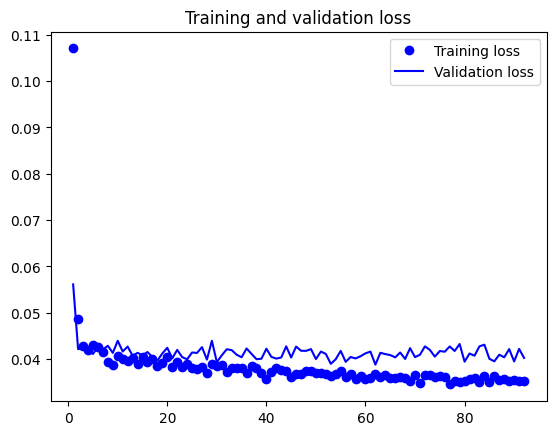

In [7]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

plot_training_loss(training_loss, validation_loss)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


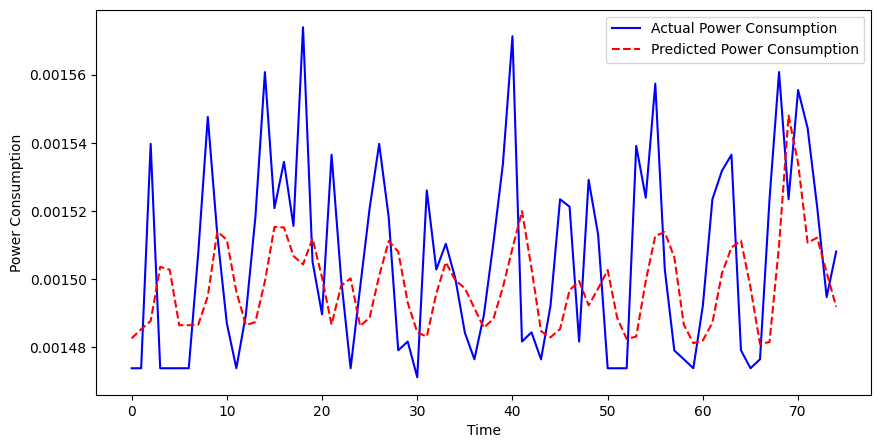

In [8]:
y_pred = model.predict(x_test)

y_test_rescaled = scaler.inverse_transform(np.column_stack([y_test] * len(features)))[:, 0]
y_pred_rescaled = scaler.inverse_transform(np.column_stack([y_pred.flatten()]*len(features)))[:, 0]

plot_power_time(y_test=y_test_rescaled, y_pred=y_pred_rescaled)

In [9]:
# Baseline
power_values = df[['power']].values
power_values_scaled = scaler.fit_transform(power_values)

y_baseline = power_values_scaled[(sequence_lenght-1):]

y_train_baseline, y_test_baseline = y_baseline[:train_size], y_baseline[train_size:-1]


baseline_model = Sequential([
    Flatten(input_shape=(x_train.shape[1], x_train.shape[2])), # TODO:Check flatten
    Dense(1)
])

baseline_model.compile(optimizer="adam", loss='mse', metrics=["mae"])

baseline_history = baseline_model.fit(x_train, y_train_baseline,
                                      epochs=100, batch_size=16,
                                      validation_data=(x_test, y_test_baseline),
                                      callbacks=[stop_training],  verbose=1)


Epoch 1/100


c:\Users\Diema2\Desktop\vs_challenge\.venv\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1920 - mae: 0.3471 - val_loss: 0.0896 - val_mae: 0.2540
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1130 - mae: 0.2752 - val_loss: 0.1074 - val_mae: 0.2740
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0950 - mae: 0.2525 - val_loss: 0.0986 - val_mae: 0.2642
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0892 - mae: 0.2448 - val_loss: 0.0865 - val_mae: 0.2494
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0767 - mae: 0.2248 - val_loss: 0.0755 - val_mae: 0.2344
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0664 - mae: 0.2081 - val_loss: 0.0663 - val_mae: 0.2206
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0628 - mae: 0.2030 - val_loss: 0.0602 - val_mae: 0.2100
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0581 - mae: 0.1964 - val_loss: 0.0559 - val_mae: 0.2021
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0528 - mae: 0.1

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


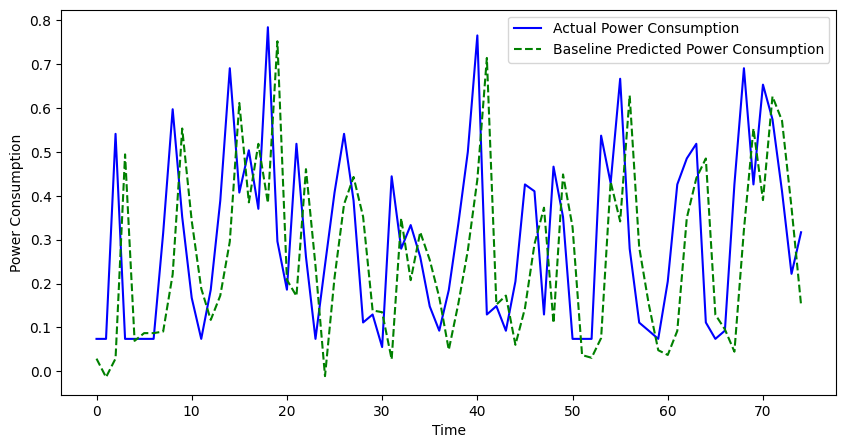

In [11]:
y_baseline_pred = baseline_model.predict(x_test)

y_test_rescaled = scaler.inverse_transform(np.column_stack([y_test] * len(features)))[:, 0]
y_baseline_pred_rescaled = scaler.inverse_transform(np.column_stack([y_baseline_pred.flatten()]*len(features)))[:, 0]

plot_power_time(y_test=y_test_rescaled,y_baseline_pred=y_baseline_pred_rescaled)

In [12]:
# Performance comparision

y_test_rescaled = scaler.inverse_transform(np.column_stack([y_test] * len(features)))[:, 0]
y_baseline_pred_rescaled = scaler.inverse_transform(np.column_stack([y_baseline_pred.flatten()]*len(features)))[:, 0]
y_pred_rescaled = scaler.inverse_transform(np.column_stack([y_pred.flatten()]*len(features)))[:, 0]

mae_lstm = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse_lstm = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))

mae_baseline = mean_absolute_error(y_test_rescaled, y_baseline_pred_rescaled)
rmse_baseline = np.sqrt(mean_squared_error(y_test_rescaled, y_baseline_pred_rescaled))

print(f"LSTM Model: MAE = {mae_lstm:.4f}, RMSE = {rmse_lstm:.4f}")
print(f"Baseline Model: MAE = {mae_baseline:.4f}, RMSE = {rmse_baseline:.4f}")

mae_improvement = (mae_baseline - mae_lstm) / mae_baseline * 100
rmse_improvement = (rmse_baseline - rmse_lstm) / rmse_baseline * 100

print(f"MAE improvement: {mae_improvement:.2f} %")
print(f"RMSE improvement: {rmse_improvement:.2f} %")

LSTM Model: MAE = 0.1640, RMSE = 0.2006
Baseline Model: MAE = 0.1880, RMSE = 0.2349
MAE improvement: 12.78 %
RMSE improvement: 14.59 %
